In [1]:
# ===== Notebook 3: Clustering Analysis =====
# Axora: Clinical Document Classification

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import (
    homogeneity_score, completeness_score, v_measure_score,
    adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
)

from collections import Counter
import textwrap
import warnings, os, sys, re, math, random

# Plot aesthetics
sns.set(style="whitegrid", font_scale=1.05)
plt.rcParams["figure.figsize"] = (10, 6)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

warnings.filterwarnings("ignore")
print("✅ Imports ready.")

✅ Imports ready.


In [2]:
# Load the same dataset used in Notebook 1
dataset = load_dataset("hpe-ai/medical-cases-classification-tutorial")

train_df = pd.DataFrame(dataset["train"])
val_df   = pd.DataFrame(dataset["validation"])
test_df  = pd.DataFrame(dataset["test"])

# Keep only the fields we need
cols = ["transcription", "medical_specialty"]
train_df = train_df[cols].copy()
val_df   = val_df[cols].copy()
test_df  = test_df[cols].copy()

# Combine for unsupervised clustering (we'll still keep true labels for evaluation)
all_df = pd.concat(
    [
        train_df.assign(split="train"),
        val_df.assign(split="val"),
        test_df.assign(split="test"),
    ],
    axis=0,
    ignore_index=True
)

# Basic overview
print("=== Dataset Overview (Notebook 3) ===")
print(f"Total documents: {len(all_df)}")
print(f"  Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
print(f"Unique specialties: {all_df['medical_specialty'].nunique()}")
print(all_df["medical_specialty"].value_counts().head())

Repo card metadata block was not found. Setting CardData to empty.


=== Dataset Overview (Notebook 3) ===
Total documents: 2464
  Train: 1724 | Val: 370 | Test: 370
Unique specialties: 13
medical_specialty
Cardiovascular / Pulmonary    742
Orthopedic                    408
Neurology                     282
Gastroenterology              222
Obstetrics / Gynecology       182
Name: count, dtype: int64


In [3]:
# Minimal cleaner for robustness (keep consistent with earlier logic)
def clean_text(text: str) -> str:
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    # keep letters, digits, and spaces; remove boilerplate symbols
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

all_df["text_clean"] = all_df["transcription"].map(clean_text)
print("Sample cleaned text:\n", textwrap.shorten(all_df.iloc[0]["text_clean"], width=200))

Sample cleaned text:
 procedure note pacemaker icd interrogation history of present illness the patient is a 67 year old gentleman who was admitted to the hospital he has had icd pacemaker implantation this is a st [...]


In [4]:
# Match Notebook 1 settings: max_features=5000, english stopwords, ngram_range=(1,2)
vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words="english",
    ngram_range=(1, 2),
    lowercase=False,   # we already lowercased
    norm="l2"          # default; good for cosine-like behavior with euclidean
)

X_all = vectorizer.fit_transform(all_df["text_clean"])
feature_names = np.array(vectorizer.get_feature_names_out())

print("=== TF-IDF Matrix ===")
print("Shape:", X_all.shape)
print("Features (first 10):", feature_names[:10])

=== TF-IDF Matrix ===
Shape: (2464, 5000)
Features (first 10): ['00' '000' '000 epinephrine' '01' '02' '03' '04' '05' '06' '07']


In [5]:
# k = 13 per spec
K = 13
kmeans = KMeans(
    n_clusters=K,
    random_state=RANDOM_STATE,
    n_init=20,
    max_iter=500,
    verbose=0
)
kmeans.fit(X_all)

cluster_labels = kmeans.labels_
all_df["cluster"] = cluster_labels

print("Cluster sizes:", pd.Series(cluster_labels).value_counts().sort_index().to_dict())

Cluster sizes: {0: 48, 1: 81, 2: 228, 3: 120, 4: 205, 5: 555, 6: 142, 7: 52, 8: 533, 9: 132, 10: 84, 11: 243, 12: 41}


In [6]:
def top_terms_per_cluster(centers, feat_names, topn=15):
    """
    centers: (K, D) array of cluster centroids
    feat_names: np.array of length D with feature names
    """
    top = {}
    for c in range(centers.shape[0]):
        # argsort descending on centroid weights
        idx = np.argsort(-centers[c])[:topn]
        top[c] = list(zip(feat_names[idx], centers[c, idx]))
    return top

# k-means centers live in dense space; ensure ndarray
centers = kmeans.cluster_centers_
cluster_top = top_terms_per_cluster(centers, feature_names, topn=15)

# Pretty print
for c in range(K):
    terms = ", ".join([t for t, _ in cluster_top[c]])
    print(f"[Cluster {c}] Top terms: {terms}")

[Cluster 0] Top terms: l5, l4, l4 l5, disc, s1, l5 s1, nerve root, lumbar, central canal, l3, root, disk, neural, nerve, central
[Cluster 1] Top terms: c5, c6, c4, c5 c6, cervical, c4 c5, c3, c7, c6 c7, c3 c4, anterior, anterior cervical, disc, disk, plate
[Cluster 2] Top terms: mg, patient, daily, history, mg daily, day, mg day, dr, discharge, past, status, disease, hospital, medications, years
[Cluster 3] Top terms: scope, procedure, colon, bronchoscope, patient, lobe, biopsies, esophagus, bronchoscopy, normal, stomach, mg, advanced, versed, withdrawn
[Cluster 4] Top terms: artery, coronary, left, right, aortic, coronary artery, valve, stenosis, catheter, right coronary, french, vessel, descending, circumflex, normal
[Cluster 5] Top terms: patient, procedure, placed, right, left, incision, using, anesthesia, used, diagnosis, removed, closed, skin, operating, fashion
[Cluster 6] Top terms: fetal, uterus, cervix, uterine, placed, patient, placenta, incision, cm, vicryl, delivery, weeks

In [10]:
# Crosstab for inspecting alignment between unsupervised clusters and actual specialties
ct = pd.crosstab(all_df["cluster"], all_df["medical_specialty"]).sort_index()
ct_total = ct.sum(axis=1)
ct_pct = (ct.T / ct.sum(axis=1)).T  # row-normalized

print("=== Cluster vs Specialty (counts) ===")
display(ct)

print("=== Cluster vs Specialty (row % normalized) ===")
display(ct_pct.style.format("{:.2%}"))

=== Cluster vs Specialty (counts) ===


medical_specialty,Cardiovascular / Pulmonary,ENT - Otolaryngology,Gastroenterology,Hematology - Oncology,Nephrology,Neurology,Neurosurgery,Obstetrics / Gynecology,Ophthalmology,Orthopedic,Pediatrics - Neonatal,Psychiatry / Psychology,Radiology
cluster,,,,,,,,,,,,,
0,0,0,0,0,0,9,12,0,0,27,0,0,0
1,0,0,0,0,0,2,38,0,0,41,0,0,0
2,70,0,13,18,17,38,2,1,0,5,0,64,0
3,50,4,66,0,0,0,0,0,0,0,0,0,0
4,192,0,1,0,2,3,1,0,0,0,0,0,6
5,158,45,38,30,15,27,54,17,46,125,0,0,0
6,2,0,18,0,1,0,0,113,0,0,0,0,8
7,2,0,0,0,0,0,0,0,0,50,0,0,0
8,126,21,62,61,24,65,0,38,6,66,64,0,0


=== Cluster vs Specialty (row % normalized) ===


medical_specialty,Cardiovascular / Pulmonary,ENT - Otolaryngology,Gastroenterology,Hematology - Oncology,Nephrology,Neurology,Neurosurgery,Obstetrics / Gynecology,Ophthalmology,Orthopedic,Pediatrics - Neonatal,Psychiatry / Psychology,Radiology
cluster,,,,,,,,,,,,,
0,0.00%,0.00%,0.00%,0.00%,0.00%,18.75%,25.00%,0.00%,0.00%,56.25%,0.00%,0.00%,0.00%
1,0.00%,0.00%,0.00%,0.00%,0.00%,2.47%,46.91%,0.00%,0.00%,50.62%,0.00%,0.00%,0.00%
2,30.70%,0.00%,5.70%,7.89%,7.46%,16.67%,0.88%,0.44%,0.00%,2.19%,0.00%,28.07%,0.00%
3,41.67%,3.33%,55.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
4,93.66%,0.00%,0.49%,0.00%,0.98%,1.46%,0.49%,0.00%,0.00%,0.00%,0.00%,0.00%,2.93%
5,28.47%,8.11%,6.85%,5.41%,2.70%,4.86%,9.73%,3.06%,8.29%,22.52%,0.00%,0.00%,0.00%
6,1.41%,0.00%,12.68%,0.00%,0.70%,0.00%,0.00%,79.58%,0.00%,0.00%,0.00%,0.00%,5.63%
7,3.85%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,96.15%,0.00%,0.00%,0.00%
8,23.64%,3.94%,11.63%,11.44%,4.50%,12.20%,0.00%,7.13%,1.13%,12.38%,12.01%,0.00%,0.00%


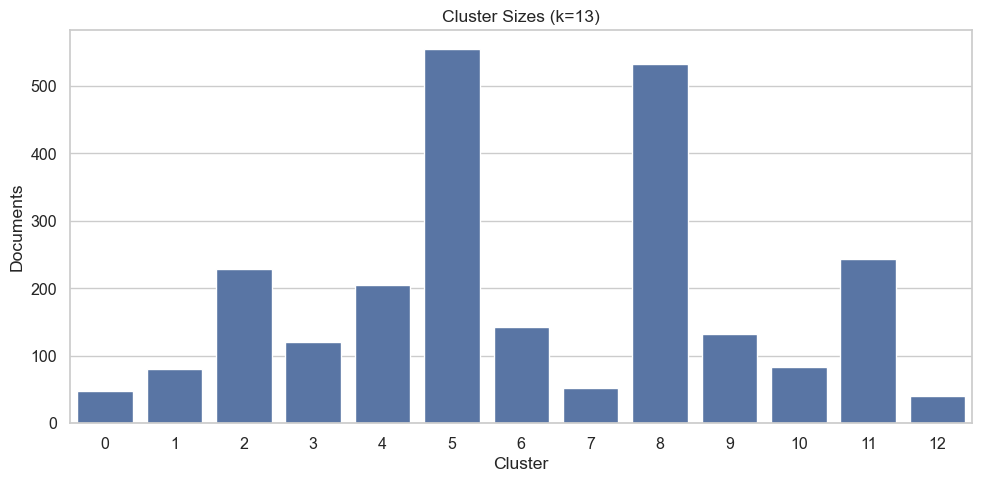

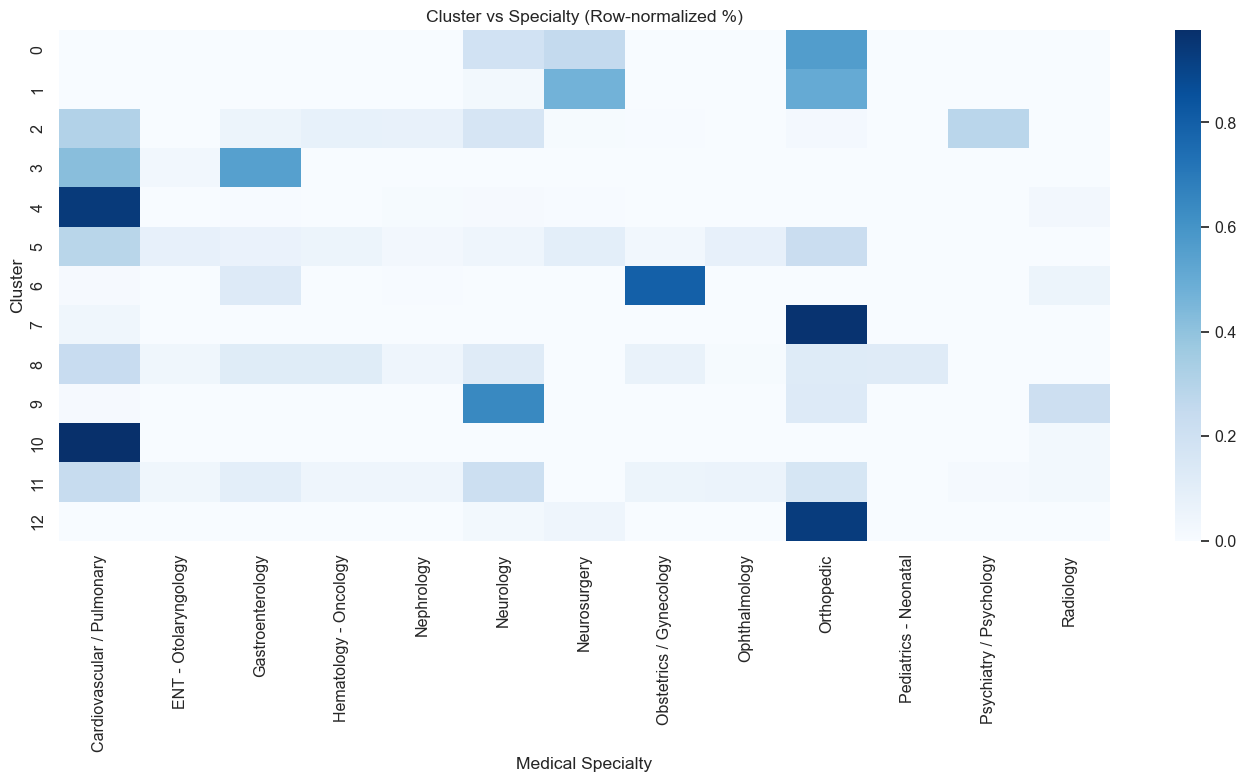

In [11]:
# Bar chart: cluster sizes
sizes = all_df["cluster"].value_counts().sort_index()
plt.figure(figsize=(10, 5))
sns.barplot(x=sizes.index, y=sizes.values)
plt.title("Cluster Sizes (k=13)")
plt.xlabel("Cluster")
plt.ylabel("Documents")
plt.tight_layout()
plt.show()

# Heatmap: top specialties per cluster (row-normalized)
plt.figure(figsize=(14, 8))
sns.heatmap(ct_pct, annot=False, cmap="Blues")
plt.title("Cluster vs Specialty (Row-normalized %)")
plt.xlabel("Medical Specialty")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

In [12]:
# External clustering metrics (use true labels only for evaluation/interpretation)
y_true = all_df["medical_specialty"].values

homog = homogeneity_score(y_true, cluster_labels)
compl = completeness_score(y_true, cluster_labels)
vmeas = v_measure_score(y_true, cluster_labels)
ari  = adjusted_rand_score(y_true, cluster_labels)
ami  = adjusted_mutual_info_score(y_true, cluster_labels)

# Silhouette (euclidean on l2-normalized tf-idf approximates cosine silhouette)
# For very large corpora, subsample to speed up:
if X_all.shape[0] > 5000:
    idx = np.random.choice(X_all.shape[0], 5000, replace=False)
    sil = silhouette_score(X_all[idx], cluster_labels[idx], metric="euclidean")
else:
    sil = silhouette_score(X_all, cluster_labels, metric="euclidean")

print("=== Cluster Quality Metrics ===")
print(f"Homogeneity:   {homog:.3f}")
print(f"Completeness:  {compl:.3f}")
print(f"V-Measure:     {vmeas:.3f}")
print(f"ARI:           {ari:.3f}")
print(f"AMI:           {ami:.3f}")
print(f"Silhouette:    {sil:.3f}")

=== Cluster Quality Metrics ===
Homogeneity:   0.316
Completeness:  0.308
V-Measure:     0.312
ARI:           0.084
AMI:           0.302
Silhouette:    0.039


In [13]:
# Find dominant specialty per cluster and purity (% of that specialty in the cluster)
dominants = []
for c in range(K):
    counts = ct.loc[c]
    top_spec = counts.idxmax()
    purity = (counts.max() / counts.sum()) if counts.sum() > 0 else 0.0
    dominants.append((c, top_spec, purity, int(counts.sum())))

dominants_df = pd.DataFrame(dominants, columns=["cluster", "dominant_specialty", "purity", "size"])\
                 .sort_values(by="purity", ascending=False)

print("=== Dominant Specialty per Cluster ===")
display(dominants_df.style.format({"purity": "{:.1%}"}))

=== Dominant Specialty per Cluster ===


,cluster,dominant_specialty,purity,size
10,10,Cardiovascular / Pulmonary,97.6%,84
7,7,Orthopedic,96.2%,52
4,4,Cardiovascular / Pulmonary,93.7%,205
12,12,Orthopedic,92.7%,41
6,6,Obstetrics / Gynecology,79.6%,142
9,9,Neurology,64.4%,132
0,0,Orthopedic,56.2%,48
3,3,Gastroenterology,55.0%,120
1,1,Orthopedic,50.6%,81
2,2,Cardiovascular / Pulmonary,30.7%,228


In [14]:
# Build a compact summary table
rows = []
for c in range(K):
    terms = [t for t, _ in cluster_top[c][:10]]
    top_specs = ct.loc[c].sort_values(ascending=False).head(3)
    rows.append({
        "cluster": c,
        "size": int(ct.loc[c].sum()),
        "top_terms": ", ".join(terms),
        "top_specialties": ", ".join([f"{k} ({v})" for k, v in top_specs.items()])
    })

summary_df = pd.DataFrame(rows).sort_values(by="size", ascending=False)
print("=== Cluster Summary (Top Terms & Specialties) ===")
display(summary_df)

=== Cluster Summary (Top Terms & Specialties) ===


,cluster,size,top_terms,top_specialties
5,5,555,"patient, procedure, placed, right, left, incis...","Cardiovascular / Pulmonary (158), Orthopedic (..."
8,8,533,"history, patient, pain, normal, past, denies, ...","Cardiovascular / Pulmonary (126), Orthopedic (..."
11,11,243,"right, ct, normal, left, contrast, impression,...","Cardiovascular / Pulmonary (58), Neurology (52..."
2,2,228,"mg, patient, daily, history, mg daily, day, mg...","Cardiovascular / Pulmonary (70), Psychiatry / ..."
4,4,205,"artery, coronary, left, right, aortic, coronar...","Cardiovascular / Pulmonary (192), Radiology (6..."
6,6,142,"fetal, uterus, cervix, uterine, placed, patien...","Obstetrics / Gynecology (113), Gastroenterolog..."
9,9,132,"unremarkable, revealed, 93, left, exam, right,...","Neurology (85), Radiology (28), Orthopedic (17)"
3,3,120,"scope, procedure, colon, bronchoscope, patient...","Gastroenterology (66), Cardiovascular / Pulmon..."
10,10,84,"stress, heart rate, rate, heart, predicted, pe...","Cardiovascular / Pulmonary (82), Radiology (2)..."
1,1,81,"c5, c6, c4, c5 c6, cervical, c4 c5, c3, c7, c6...","Orthopedic (41), Neurosurgery (38), Neurology (2)"


In [ ]:
# Exports to help with the report/dashboards
os.makedirs("artifacts_clustering", exist_ok=True)
summary_df.to_csv("artifacts_clustering/cluster_summary.csv", index=False)
ct.to_csv("artifacts_clustering/cluster_vs_specialty_counts.csv")
ct_pct.to_csv("artifacts_clustering/cluster_vs_specialty_rowpct.csv")

# Document-level mapping
doc_map = all_df[["split", "medical_specialty", "cluster"]].copy()
doc_map.to_csv("artifacts_clustering/document_cluster_map.csv", index=False)

print("✅ Exported:")
print("- artifacts_clustering/cluster_summary.csv")
print("- artifacts_clustering/cluster_vs_specialty_counts.csv")
print("- artifacts_clustering/cluster_vs_specialty_rowpct.csv")
print("- artifacts_clustering/document_cluster_map.csv")